In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import scipy.sparse.linalg as spla
from scipy.sparse import csr_matrix
from matplotlib.animation import ArtistAnimation
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

Δx: 1.0 Δt: 0.2 CFL: 0.2 ν: 0.5 d: 0.1


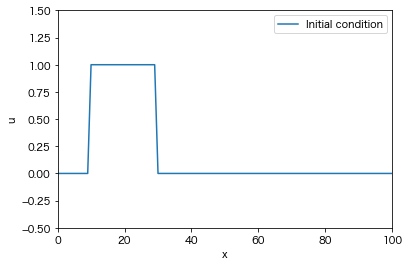

In [3]:
# Make stencils
# Creat square wave
Num_stencil_x = 101
x_array = np.arange(Num_stencil_x)
u_array = np.where(((x_array >= 30) |(x_array < 10)), 0.0, 1.0)
u_lower_boundary = 0.0
u_upper_boundary = 0.0
Time_step = 300
Delta_x = max(x_array) / (Num_stencil_x-1)
C = 1
Nu = 0.5
Delta_t = 0.2
CFL = C * Delta_t / Delta_x
diffusion_number = Nu * Delta_t / Delta_x**2
total_movement = C * Delta_t * (Time_step+1)
exact_u_array = np.where(((x_array >= 30 + total_movement) |(x_array < 10 + total_movement)), 0.0, 1.0)
plt.plot(x_array, u_array, label="Initial condition")
plt.legend(loc="upper right")
plt.xlabel("x")
plt.ylabel("u")
plt.xlim(0, max(x_array))
plt.ylim(-0.5,1.5)
print("Δx:", Delta_x, "Δt:", Delta_t, "CFL:", CFL, "ν:", Nu, "d:", diffusion_number)

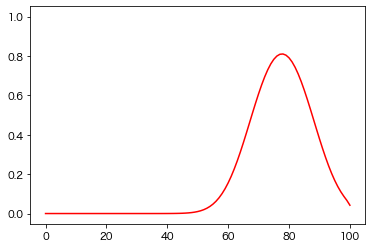

In [4]:
def solve_advection_cip(u_cip, partial_u_cip, lower_boundary, velocity=C):
    u_old = u_cip.copy()
    partial_u_old = partial_u_cip.copy()
    u_cip[0] = lower_boundary
    partial_u_cip[0] = 0  # 境界値を0とした
    a = (partial_u_old[1:] + partial_u_old[:-1]) / Delta_x**2 - 2.0 * np.diff(u_old, n=1) / Delta_x**3
    b = 3 * (u_old[:-1] - u_cip[1:]) / Delta_x**2 + (2.0*partial_u_old[1:] + partial_u_old[:-1]) / Delta_x
    c = partial_u_old[1:]
    d = u_old[1:]
    xi = - velocity * Delta_t  # C > 0
    u_cip[1:] = a * xi**3 + b * xi**2 + c * xi + d
    partial_u_cip[1:] = 3 * a * xi**2 + 2 * b * xi + c
    return u_cip, partial_u_cip

def solve_diffusion(u_array, upper_boundary, lower_boundary, diffusion_number):
    a_matrix = np.identity(len(u_array)) * 2 *(1/diffusion_number+1) \
                - np.eye(len(u_array), k=1) \
                - np.eye(len(u_array), k=-1)
    temp_u_array = np.append(np.append(
                        lower_boundary, 
                        u_array), upper_boundary)
    b_array = 2 * (1/diffusion_number - 1) * u_array + temp_u_array[2:] + temp_u_array[:-2]
    b_array[0] += lower_boundary
    b_array[-1] += upper_boundary
    a_csr = scipy.sparse.csr_matrix(a_matrix)
    u_array = spla.isolve.bicgstab(a_csr, b_array)[0]
    return u_array

fig = plt.figure()
images = []
u_cip= u_array.copy()
partial_u_cip = ((np.append(u_cip[1:], u_upper_boundary) + u_cip)/2 - (np.append(u_lower_boundary, u_cip[:-1]) + u_cip)/2)/ Delta_x
# 時間発展させる
for n in range(Time_step):
    u_cip_star, partial_u_cip_star = solve_advection_cip(u_cip, partial_u_cip, u_lower_boundary)
    u_cip = solve_diffusion(u_cip_star, u_upper_boundary, u_lower_boundary, diffusion_number)
    partial_u_cip = solve_diffusion(partial_u_cip_star, 0, 0, diffusion_number)  # 境界値を0とした
    if n % 10 == 0:
        line, = plt.plot(x_array, u_cip, "r")
        images.append([line])
# plt.plot(x_array, u_array, label="Initial condition")
# plt.plot(x_array, u_cip, label="CIP method")
animatoin_gif = ArtistAnimation(fig, images)
animatoin_gif.save('linear_adv_diff.gif', writer="pillow")
plt.show()

# バーガーズ方程式

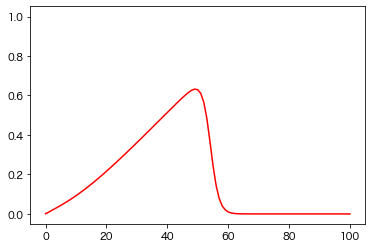

In [5]:
def solve_advection_cip(u_cip, partial_u_cip, lower_boundary, dt=Delta_t, velocity=C):
    """
    CIP法によって移流方程式を解く
    """
    u_old = u_cip.copy()
    partial_u_old = partial_u_cip.copy()
    u_cip[0] = lower_boundary
    partial_u_cip[0] = (u_cip[0] - lower_boundary) / Delta_x
    a = (partial_u_old[1:] + partial_u_old[:-1]) / Delta_x**2 - 2.0 * np.diff(u_old, n=1) / Delta_x**3
    b = 3 * (u_old[:-1] - u_cip[1:]) / Delta_x**2 + (2.0*partial_u_old[1:] + partial_u_old[:-1]) / Delta_x
    c = partial_u_old[1:]
    d = u_old[1:]
    xi = - velocity * dt  # C > 0
    u_cip[1:] = a * xi**3 + b * xi**2 + c * xi + d
    partial_u_cip[1:] = 3 * a * xi**2 + 2 * b * xi + c
    return u_cip, partial_u_cip

def solve_diffusion(u_array, lower_boundary, upper_boundary, diffusion_number, 
                    update_partial=False, u_array_integral=None, prop_lambda=1/2):
    """
    拡散方程式を解く。

    Parameters
    ----------
    u_array : array-like
        nのベクトル
    upper_boundary : numpy.float64
        u_array[n]の隣
    lower_boundary : numpy.float64
        u_array[0]の隣
    diffusion_number : numpy.float64
        拡散数。正の数。
    update_partial : Bool, default False
        微分式の更新の時Trueにする。
    u_array_integral : array-like, default None
        微分式の更新の時に使用。[lower_boundary, u_array, upper_boudary]の形のn+2のベクトル。
    prop_lambda : numpy.float64, default 1/2
        0: Explicit method. Centered sapce difference.
        1/2: 半陰解法。Crank-Nicolson scheme
        1: Fully implicit method. 時間後退差分。

    Returns
    -------
    u_array : array-like
        n行の行列
    """
    a_matrix = np.identity(len(u_array)) * (1/diffusion_number+2 * prop_lambda) \
                - prop_lambda * np.eye(len(u_array), k=1) \
                - prop_lambda * np.eye(len(u_array), k=-1)
    temp_u_array = np.append(np.append(
                             lower_boundary, 
                             u_array), upper_boundary)
    b_array = (1/diffusion_number - 2 * (1-prop_lambda)) * u_array + (1-prop_lambda)*temp_u_array[2:] + (1-prop_lambda)*temp_u_array[:-2]
    b_array[0] += prop_lambda * lower_boundary
    b_array[-1] += prop_lambda * upper_boundary
    if update_partial:
        # 微分式の更新の時にこれを実行
        b_array -= ((u_array_integral[2:] - u_array_integral[:-2]) / 2 / Delta_x)**2
    a_csr = scipy.sparse.csr_matrix(a_matrix)
    u_array = spla.isolve.bicgstab(a_csr, b_array)[0]
    return u_array

fig = plt.figure(1)
images = []
u_cip= u_array.copy()
partial_u_cip = ((np.append(u_cip[1:], u_upper_boundary) + u_cip)/2 
                 - (np.append(u_lower_boundary, u_cip[:-1]) + u_cip)/2)/ Delta_x
# 安定条件の設定
cfl_condition = 1
diffusion_number_restriction = 1/2
# 時間発展させる
for n in range(Time_step):
    delta_t = Delta_t
    cfl_max = np.max(np.abs(u_cip)) * delta_t / Delta_x
    diffusion_max = Nu * delta_t / Delta_x**2
    if cfl_max > cfl_condition:
        # CFL条件の判定
        # cfl_conditionより大きかったら、時間刻み幅dtを小さくしてCFL条件を満たすようにする
        delta_t = cfl_condition * Delta_x / np.max(np.abs(u_cip))
    if diffusion_number > diffusion_number_restriction:
        # 拡散数の判定
        # diffusion_number_restrictionより大きかったら、時間刻み幅dtを小さくして拡散数の条件を満たすようにする
        delta_t = diffusion_max * Delta_x ** 2 / Nu
    # 移流方程式を解く
    u_cip_star, partial_u_cip_star = solve_advection_cip(u_cip, partial_u_cip, u_lower_boundary, delta_t, u_cip[1:])
    # 拡散方程式を解く
    u_cip = solve_diffusion(u_cip_star, u_lower_boundary, u_upper_boundary, diffusion_number)
    u_cip_with_boundary = np.append(np.append(
                                     u_lower_boundary, 
                                     u_cip_star), 
                                     u_upper_boundary)
    partial_u_cip = solve_diffusion(partial_u_cip_star, 0, 0, diffusion_number, 
                                    update_partial=True, 
                                    u_array_integral=u_cip_with_boundary)  # 境界値を0とした
    if n % 10 == 0:
        line, = plt.plot(x_array, u_cip, "r")
        images.append([line])
# plt.plot(x_array, u_array, label="Initial condition")
# plt.plot(x_array, u_cip, label="Burgers")
animatoin_gif = ArtistAnimation(fig, images)
animatoin_gif.save('burgers.gif', writer="pillow")

# 2次元に拡張

Δx: 1.0 Δt: 0.2 CFL: 0.2 ν: 0.5 d: 0.1


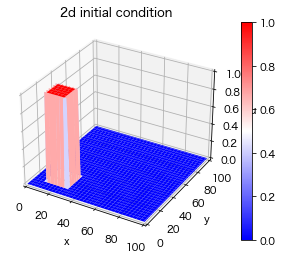

In [6]:
# Make stencils
# Creat square wave
Num_stencil_x = 101
Num_stencil_y = 101
x_stencil = np.arange(Num_stencil_x)
y_stencil = np.arange(Num_stencil_y)
x_array, y_array = np.meshgrid(x_stencil, y_stencil)
u_array = np.where(((30 >x_array) & (x_array >= 10) & (30 > y_array) & (y_array >= 10)), 1.0, 0.0)
u_x_lower_boundary = np.zeros(Num_stencil_x)
u_y_lower_boundary = np.zeros(Num_stencil_y)
u_x_upper_boundary = np.zeros(Num_stencil_x)
u_y_upper_boundary = np.zeros(Num_stencil_y)
ux_x_lower_boundary = np.zeros(Num_stencil_x)
ux_y_lower_boundary = np.zeros(Num_stencil_y)
ux_x_upper_boundary = np.zeros(Num_stencil_x)
ux_y_upper_boundary = np.zeros(Num_stencil_y)
uy_x_lower_boundary = np.zeros(Num_stencil_x) 
uy_y_lower_boundary = np.zeros(Num_stencil_y)
uy_x_upper_boundary = np.zeros(Num_stencil_x)
uy_y_upper_boundary = np.zeros(Num_stencil_y)
coner_xlow_ylow = np.zeros(1)
coner_xup_ylow = np.zeros(1)
coner_xlow_yup = np.zeros(1)
coner_xup_yup = np.zeros(1)
Time_step = 300
Delta_x = max(x_stencil) / (Num_stencil_x-1)
Delta_y = max(y_stencil) / (Num_stencil_y-1)
C = 1
Nu = 0.5
Delta_t = 0.2
CFL_x = C * Delta_t / Delta_x
CFL_y = C * Delta_t / Delta_y
CFL = min(CFL_x, CFL_y)
diffusion_number_x = Nu * Delta_t / Delta_x**2
diffusion_number_y = Nu * Delta_t / Delta_y**2
total_movement = C * Delta_t * (Time_step+1)
print("Δx:", Delta_x, "Δt:", Delta_t, "CFL:", CFL_x, "ν:", Nu, "d:", diffusion_number_x)
fig = plt.figure(2)
axe = fig.add_subplot(111, projection='3d')
surface = axe.plot_surface(x_array, y_array, u_array, cmap="bwr", label="Initail condition")
fig.colorbar(surface)
axe.set_xlabel("x")
axe.set_ylabel("y")
axe.set_zlabel("u")
axe.set_xlim(0, 100)
axe.set_ylim(0, 100)
axe.set_zlim(0, 1)
axe.set_title("2d initial condition")
plt.show()

KeyboardInterrupt: 

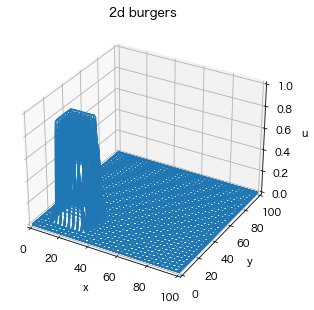

In [7]:
def solve_advection_cip_2d(u_cip, ux_cip, uy_cip, 
                           x_lower_boundary, x_upper_boundary, 
                           y_lower_boundary, y_upper_boundary,
                           ux_x_lower_boundary, ux_x_upper_boundary,
                           ux_y_lower_boundary, ux_y_upper_boundary,
                           uy_x_lower_boundary, uy_x_upper_boundary,
                           uy_y_lower_boundary, uy_y_upper_boundary,
                           coner_ll, coner_lu, coner_ul, coner_uu,
                           dt=Delta_t, 
                           velocity_x=C, velocity_y=0.0):
    """
    Solve the advection equation by using CIP method.

       -  x  +
     - 5333337
       1*****2
     y 1*****2
       1*****2
       1*****2
     + 6444448

    *: u_cip or ux_cip or uy_cip
    1: x_lower_boundary or ux_x_lower_boundary or uy_x_lower_boundary
    2: x_upper_boundary or ux_x_upper_boundary or uy_x_upper_boundary
    3: y_lower_boundary or ux_y_lower_boundary or uy_y_lowerboundary
    4: y_upper_boundary or ux_y_upper_boundary or uy_y_upper_boundary
    5: coner_ll
    6: coner_lu
    7: coner_ul
    8: coner_uu
    """
    if type(velocity_x) is not np.ndarray:
        velocity_x = np.ones(u_cip.shape) * velocity_x
    if type(velocity_y) is not np.ndarray:
        velocity_y = np.ones(u_cip.shape) * velocity_y
    # Memory the present values
    u_old = u_cip.copy()
    ux_old = ux_cip.copy()
    uy_old = uy_cip.copy()

    # Prepare for calculation
    xi = - np.sign(velocity_x) * velocity_x * dt
    zeta = - np.sign(velocity_y) * velocity_y * dt
    dx = - np.sign(velocity_x) * Delta_x
    dy = - np.sign(velocity_y) * Delta_y

    # Set the neighbourhood values for reducing the for loop
    u_with_xlower_bc = np.concatenate([x_lower_boundary[:, np.newaxis], u_old[:, :-1]], axis=1)
    u_with_xupper_bc = np.concatenate([u_old[:, 1:], x_upper_boundary[:, np.newaxis]], axis=1)
    u_with_ylower_bc = np.concatenate([y_lower_boundary[np.newaxis, :], u_old[:-1, :]], axis=0)
    u_with_yupper_bc = np.concatenate([u_old[1:, :], y_upper_boundary[np.newaxis, :]], axis=0)
    temp_u_with_all_bc = np.concatenate([x_lower_boundary[:, np.newaxis], u_old, 
                                         x_upper_boundary[:, np.newaxis]], axis=1)
    u_with_all_bc = np.concatenate([np.concatenate([coner_ll, y_lower_boundary,coner_ul])[np.newaxis, :],
                                    temp_u_with_all_bc,
                                    np.concatenate([coner_lu, y_upper_boundary, coner_uu])[np.newaxis, :]], axis=0)

    u_next_x = np.where(velocity_x > 0.0, u_with_xlower_bc, u_with_xupper_bc)
    u_next_y = np.where(velocity_y > 0.0, u_with_ylower_bc, u_with_yupper_bc)
    u_next_xy = np.where(((velocity_x > 0.0) & (velocity_y > 0.0)), u_with_all_bc[:-2, :-2], 
                    np.where(((velocity_x < 0.0) & (velocity_y > 0.0)), u_with_all_bc[:-2, 2:],
                        np.where(((velocity_x > 0.0) & (velocity_y < 0.0)), u_with_all_bc[2:, :-2], u_with_all_bc[2:, 2:])))
    ux_next_x = np.where(velocity_x > 0, 
                        np.concatenate([ux_x_lower_boundary[:, np.newaxis], ux_old[:, :-1]], axis=1), 
                        np.concatenate([ux_old[:, 1:], ux_x_upper_boundary[:, np.newaxis]], axis=1))
    ux_next_y = np.where(velocity_y > 0, 
                        np.concatenate([ux_y_lower_boundary[np.newaxis, :], ux_old[:-1, :]], axis=0), 
                        np.concatenate([ux_old[1:, :], ux_y_upper_boundary[np.newaxis, :]], axis=0))
    uy_next_x = np.where(velocity_x > 0, 
                        np.concatenate([uy_x_lower_boundary[:, np.newaxis], uy_old[:, :-1]], axis=1), 
                        np.concatenate([uy_old[:, 1:], uy_x_upper_boundary[:, np.newaxis]], axis=1))
    uy_next_y = np.where(velocity_y > 0, 
                        np.concatenate([uy_y_lower_boundary[np.newaxis, :], uy_old[:-1, :]], axis=0), 
                        np.concatenate([uy_old[1:, :], uy_y_upper_boundary[np.newaxis, :]], axis=0))
    u_next_x = np.where(velocity_x == 0.0, u_old, u_next_x)
    u_next_y = np.where(velocity_y == 0.0, u_old, u_next_y)
    u_next_xy = np.where(((velocity_x == 0.0) & (velocity_y != 0.0)), u_next_y, 
                    np.where(((velocity_x != 0.0) & (velocity_y == 0.0)), u_next_x,
                        np.where(((velocity_x == 0.0) & (velocity_y == 0.0)), u_old, u_next_xy)))
    ux_next_x = np.where(velocity_x == 0, ux_old, ux_next_x)
    ux_next_y = np.where(velocity_y == 0, ux_old, ux_next_y)
    uy_next_x = np.where(velocity_x == 0, uy_old, uy_next_x)
    uy_next_y = np.where(velocity_y == 0, uy_old, uy_next_y)
    dx = np.where(velocity_x == 0, 1.0, dx)
    dy = np.where(velocity_y == 0, 1.0, dy)

    # Calculate the cip coefficient
    c_1 = - (u_next_xy - u_next_x - u_next_y + u_old) / dx / dy \
            + (ux_next_y - ux_old) / dy + (uy_next_x - uy_old) / dx
    c_3 = (uy_next_x - uy_old) / dx ** 2 - c_1 / dx
    c_2 = (ux_next_y - ux_old) / dy ** 2 - c_1 / dy
    a_1 = ux_old
    a_2 = 3 * (u_next_x - u_old) / dx**2 - (ux_next_x + 2 * ux_old) / dx
    a_3 = (ux_next_x - ux_old) / 3 / dx**2 - 2 * a_2 / 3 / dx
    b_1 = uy_old
    b_2 = 3 * (u_next_y - u_old) / dy**2 - (uy_next_y + 2 * uy_old) / dy
    b_3 = (uy_next_y - uy_old) / 3 / dy**2 - 2 * b_2 / 3 / dy
    d = u_old

    # Calculate the values
    u_cip = a_3 * xi**3 + a_2 * xi**2 + a_1 * xi + \
            b_3 * zeta**3 + b_2 * zeta**2 + b_1 * zeta + \
            c_3 * xi**2 * zeta + c_2 * xi * zeta**2 + c_1 * xi * zeta + d
    ux_cip = 3 * a_3 * xi**2   + 2 * a_2 * xi + a_1 + 2 * c_3 * xi * zeta + c_2 * zeta**2 + c_1 * zeta
    uy_cip = 3 * b_3 * zeta**2 + 2 * b_2 * zeta + b_1 + 2 * c_2 * xi * zeta + c_2 * xi**2 + c_1 * xi
    return u_cip, ux_cip, uy_cip

def update_boundary_condition(u_cip, x_lower_boundary, x_upper_boundary, 
                             y_lower_boundary, y_upper_boundary):
    x_lower_boundary = min(0.0, np.min(u_cip[:, 0]))
    x_upper_boundary = max(0.0, np.max(u_cip[:, -1]))
    y_lower_boundary = min(0.0, np.min(u_cip[0, :]))
    y_upper_boundary = max(0.0, np.max(u_cip[-1, :]))

def solve_diffusion_2d(u_2d, 
                       x_lower_boundary, x_upper_boundary, 
                       y_lower_boundary, y_upper_boundary,
                       d_number_x, d_number_y,
                       v_x=None, v_y=None,
                       v_x_lower_bc=None, v_x_upper_bc=None,
                       v_y_lower_bc=None, v_y_upper_bc=None,
                       update_partial=0, u_array_integral=None, 
                       prop_lambda=1/2):
    """
    拡散方程式を解く。非移流項の要素も含んでいる。

    Parameters
    ----------
    u_2d : array-like
        nx×ny行の行列
    upper_boundary : numpy.float64
        u_array[n]の隣
    lower_boundary : numpy.float64
        u_array[0]の隣
    d_number_* : numpy.float64
        拡散数。正の数。
    update_partial : Bool, default False
        微分式の更新の時Trueにする。
    u_array_integral : array-like, default None
        微分式の更新の時に使用。[lower_boundary, u_array, upper_boudary]の形のn+2のベクトル。
    prop_lambda : numpy.float64, default 1/2
        0: Explicit method. Centered sapce difference.
        1/2: 半陰解法。Crank-Nicolson scheme
        1: Fully implicit method. 時間後退差分。

    Returns
    -------
    u_2d : array-like
        nx×ny行の行列
    """
    # 行列サイズ取得
    nx, ny = u_2d.shape
    matrix_size = nx * ny
    # Ax=bのAとbを作成
    s_param = 1 + 2 * prop_lambda * (d_number_x + d_number_y)
    t_param = 1 - 2 * (1 - prop_lambda) * (d_number_x + d_number_y)
    east_matrix = np.eye(matrix_size, k=1)
    east_matrix[np.arange(nx-1, matrix_size-nx, nx), np.arange(nx, matrix_size-nx+1, nx)] *= 0
    west_matrix = np.eye(matrix_size, k=-1)
    west_matrix[np.arange(nx, matrix_size-nx+1, nx), np.arange(nx-1, matrix_size-nx, nx)] *= 0
    a_matrix = np.identity(matrix_size) * s_param \
                - prop_lambda * d_number_x * east_matrix \
                - prop_lambda * d_number_x * west_matrix \
                - prop_lambda * d_number_y * np.eye(matrix_size, k=nx) \
                - prop_lambda * d_number_y * np.eye(matrix_size, k=-nx)
    b_array = t_param * u_2d.flatten()
    temp_csr = d_number_x * (1 - prop_lambda) * (csr_matrix(east_matrix) + csr_matrix(west_matrix)) \
               + d_number_y * (1 - prop_lambda) * (csr_matrix(np.eye(matrix_size, k=nx)) + csr_matrix(np.eye(matrix_size, k=-nx)))
    b_array += temp_csr.dot(b_array)
    # 境界条件を設定 / Setting of boundary condition
    b_array[:nx] += ((1 - prop_lambda) * y_lower_boundary + prop_lambda * y_lower_boundary) * d_number_y
    b_array[matrix_size-nx:] += ((1 - prop_lambda) * y_upper_boundary + prop_lambda * y_upper_boundary) * d_number_y
    b_array[np.arange(nx-1, matrix_size, nx)] += ((1 - prop_lambda) * x_upper_boundary + prop_lambda * x_upper_boundary) * d_number_x
    b_array[np.arange(0, matrix_size-nx+1, nx)] += ((1 - prop_lambda) * x_lower_boundary + prop_lambda * x_lower_boundary) * d_number_x
    if update_partial == 1:
        # x方向の微分式の更新の時に実行される。普通の拡散方程式を解く時は使わない。
        if type(v_x) is not np.ndarray:
            v_x = np.ones(u_2d.shape) * v_x
        if type(v_y) is not np.ndarray:
            v_y = np.ones(u_2d.shape) * v_y
        v_x_with_bc = np.concatenate([v_x_lower_bc[:, np.newaxis], v_x, v_x_upper_bc[:, np.newaxis]], axis=1)
        v_y_with_bc = np.concatenate([v_y_lower_bc[:, np.newaxis], v_y, v_y_upper_bc[:, np.newaxis]], axis=1)
        u_with_xbc = np.concatenate([x_lower_boundary[:, np.newaxis], u_array_integral, x_upper_boundary[:, np.newaxis]], axis=1)
        u_with_ybc = np.concatenate([y_lower_boundary[np.newaxis, :], u_array_integral, y_upper_boundary[np.newaxis, :]], axis=0)
        temp_b_array = - ((v_x_with_bc[:, 2:] - v_x_with_bc[:, :-2]) / 2 / Delta_x) * \
                             ((u_with_xbc[:, 2:] - u_with_xbc[:, :-2]) / 2 / Delta_x)
        temp_b_array -= ((v_y_with_bc[:, 2:] - v_y_with_bc[:, :-2]) / 2 / Delta_x) * \
                               ((u_with_ybc[2:, :] - u_with_ybc[:-2, :]) / 2 / Delta_y)
        b_array += temp_b_array.flatten()
    elif update_partial == 2:
        # y方向の微分式の更新の時に実行される。普通の拡散方程式を解く時は使わない。
        if type(v_x) is not np.ndarray:
            v_x = np.ones(u_2d.shape) * v_x
        if type(v_y) is not np.ndarray:
            v_y = np.ones(u_2d.shape) * v_y
        v_x_with_bc = np.concatenate([v_x_lower_bc[np.newaxis, :], v_x, v_x_upper_bc[np.newaxis, :]], axis=0)
        v_y_with_bc = np.concatenate([v_y_lower_bc[np.newaxis, :], v_y, v_y_upper_bc[np.newaxis, :]], axis=0)
        u_with_xbc = np.concatenate([x_lower_boundary[:, np.newaxis], u_array_integral, x_upper_boundary[:, np.newaxis]], axis=1)
        u_with_ybc = np.concatenate([y_lower_boundary[np.newaxis, :], u_array_integral, y_upper_boundary[np.newaxis, :]], axis=0)

        temp_b_array = - ((v_x_with_bc[2:, :] - v_x_with_bc[:-2, :]) / 2 / Delta_y) * \
                             ((u_with_xbc[:, 2:] - u_with_xbc[:, :-2]) / 2 / Delta_x) \
                       - ((v_y_with_bc[2:, :] - v_y_with_bc[:-2, :]) / 2 / Delta_y) * \
                               ((u_with_ybc[2:, :] - u_with_ybc[:-2, :]) / 2 / Delta_y)
        b_array += temp_b_array.flatten()
    a_csr = csr_matrix(a_matrix)
    u_2d = spla.isolve.bicgstab(a_csr, b_array)[0]
    return u_2d.reshape(nx, ny)

# 2d Bugers 方程式
images = []
fig_5 = plt.figure(5, figsize=(5,5))
axe = fig_5.add_subplot(111, projection='3d')
# surface = axe.plot_surface(x_array, y_array, u_array, cmap="bwr")
# fig.colorbar(surface)
axe.set_xlabel("x")
axe.set_ylabel("y")
axe.set_zlabel("u")
axe.set_xlim(0, 100)
axe.set_ylim(0, 100)
axe.set_zlim(0, 1)
axe.set_title("2d burgers")

u_cip = u_array.copy()
partial_u_cip_x \
    = (np.concatenate([u_cip[:, 1:], u_x_upper_boundary[:, np.newaxis]], axis=1) \
       - np.concatenate([u_x_lower_boundary[:, np.newaxis], u_cip[:, :-1]], axis=1)) / 2 / Delta_x
partial_u_cip_y \
    = (np.concatenate([u_cip[1:, :], u_y_upper_boundary[np.newaxis, :]], axis=0) \
       - np.concatenate([u_y_lower_boundary[np.newaxis, :], u_cip[:-1, :]], axis=0)) / 2 / Delta_y
u_boundary = (u_x_lower_boundary, u_x_upper_boundary, u_y_lower_boundary, u_y_upper_boundary)

# 安定条件の設定
cfl_condition = 1
diffusion_number_restriction = 1/2
# 時間発展させる
for n in range(21):
    update_boundary_condition(u_cip, *u_boundary)
    delta_t = Delta_t
    cfl_max = np.max(np.abs(u_cip)) * delta_t / min(Delta_x, Delta_y)
    if cfl_max > cfl_condition:
        # CFL条件の判定
        # cfl_conditionより大きかったら、時間刻み幅dtを小さくしてCFL条件を満たすようにする
        delta_t = CFL * min(Delta_x, Delta_y) / np.max(np.abs(u_cip))
    diffusion_max = Nu * delta_t / (Delta_x**2 + Delta_y**2)
    if diffusion_max > diffusion_number_restriction:
        # 拡散数の判定
        # diffusion_number_restrictionより大きかったら、時間刻み幅dtを小さくして拡散数の条件を満たすようにする
        delta_t = diffusion_max * (Delta_x ** 2 + Delta_y**2) / Nu
        diffusion_number_x *= delta_t / Delta_t
        diffusion_number_y *= delta_t / Delta_t
    u_props = (u_cip, partial_u_cip_x, partial_u_cip_y)
    u_boundary = (u_x_lower_boundary, u_x_upper_boundary, u_y_lower_boundary, u_y_upper_boundary)
    ux_boundary = (ux_x_lower_boundary, ux_x_upper_boundary, ux_y_lower_boundary, ux_y_upper_boundary)
    uy_boundary = (uy_x_lower_boundary, uy_x_upper_boundary, uy_y_lower_boundary, uy_y_upper_boundary)
    u_coner = (coner_xlow_ylow, coner_xlow_yup, coner_xup_ylow, coner_xup_yup)
    diffusion_numbers = (diffusion_number_x, diffusion_number_y)
    u_cip_star, partial_u_cip_x_star, partial_u_cip_y_star \
        = solve_advection_cip_2d(*u_props, *u_boundary, *ux_boundary, *uy_boundary, *u_coner, dt=delta_t)
    velocities = (u_cip_star, 0.0)
    velocity_x_boundaries = (u_x_lower_boundary, u_x_upper_boundary, u_y_lower_boundary, u_y_upper_boundary)
    velocity_y_boundaries = (u_x_lower_boundary, u_x_upper_boundary, u_y_lower_boundary, u_y_upper_boundary) # とりあえず
    u_cip = solve_diffusion_2d(u_cip_star, *u_boundary, *diffusion_numbers)
    partial_u_cip_x = solve_diffusion_2d(partial_u_cip_x_star, *ux_boundary, *diffusion_numbers,
                                         *velocities, *velocity_x_boundaries,
                                         update_partial=1, u_array_integral=u_cip_star)
    partial_u_cip_y = solve_diffusion_2d(partial_u_cip_y_star, *uy_boundary, *diffusion_numbers,
                                         *velocities, *velocity_y_boundaries,
                                         update_partial=2, u_array_integral=u_cip_star)

    if n % 1 == 0 and n > 0:
        img = axe.plot_wireframe(x_array, y_array, u_cip, cmap="bwr")
        images.append([img])
ani = animation.ArtistAnimation(fig_5, images, interval=100)
# ani.save('wf_anim_art.mp4',writer='ffmpeg',dpi=100)
ani.save('2d-burgers.gif', writer="pillow")
HTML(ani.to_html5_video())